# **Modelo analítico para órdenes no tomadas**

## 1. Carga de fuentes de información
### _El objetivo de esta sección es cargar los datos en el notebook y entender los tipos de variables_

In [1]:
# Importar la librería pandas para la carga y entendimiento de la fuente de información. Adicionalmente importa
# la librería Mathplotlib para realizar gráficas en caso de que se requiera, así como la librería numpy para convertir
# las fuentes de datos en arreglos 

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Se modifica el formato en el que se muestra la información con esta librería para evitar salidas en notación científica
pd.options.display.float_format = '{:20,.2f}'.format

# Se lee el archivo fuente y se guarda en la variable arch_fuente
arch_fuente = pd.read_csv('./orders.csv',)

# Tipos de datos
tipos_datos = arch_fuente.dtypes
print(tipos_datos)


order_id               int64
store_id               int64
to_user_distance     float64
to_user_elevation    float64
total_earning          int64
created_at            object
taken                  int64
dtype: object


In [2]:
# Se visualizan los encabezados para entender la estructura de la variable created_at

arch_fuente.head()

,order_id,store_id,to_user_distance,to_user_elevation,total_earning,created_at,taken
0,14364873,30000009,2.48,-72.72,4200,2017-09-07T20:02:17Z,0
1,14370123,30000058,0.45,37.75,4200,2017-09-07T20:13:16Z,0
2,14368534,900003684,2.03,207.19,4000,2017-09-07T20:07:23Z,0
3,14370258,900014452,2.67,1.72,4400,2017-09-07T20:15:19Z,1
4,14369923,900014085,0.97,117.43,3450,2017-09-07T20:12:14Z,1


## 2. Entendimiento de la data histórica y transformaciones
### _El objetivo de esta sección es tener un entendimiento del set de datos y realizar las transformaciones necesarias para que los datos puedan utilizarse como soporte a las decisiones de Rappi respecto a las órdenes no tomadas_

In [3]:
# Se identifica si se encuentran valores faltantes.
arch_fuente.isnull().sum()

order_id             0
store_id             0
to_user_distance     0
to_user_elevation    0
total_earning        0
created_at           0
taken                0
dtype: int64

In [4]:
# Se eliminan las columnas de order_id y store_id debido a que no deberían hacer parte del análisis
del arch_fuente['order_id']
del arch_fuente['store_id']

In [5]:
# Se crean las variables adicionales en el dataset que permitan saber el día de la semana y la hora de la orden

fecha = arch_fuente['created_at'].str.split("T")

# Extraer la fecha y la hora de los pedidos

arch_fuente['fecha'] = fecha.map(lambda x: x[0])
arch_fuente['hora'] = fecha.map(lambda x: x[1])
arch_fuente['hora'] = arch_fuente['hora'].map(lambda x: str(x)[:-1])

# Se obtienen las horas del día
hora = arch_fuente['hora'].str.split(':')
arch_fuente['hora'] = hora.map(lambda x: x[0])

# Cambiar el formato de la fecha y obtener el día de la semana
arch_fuente['fecha'] =  pd.to_datetime(arch_fuente['fecha'], format='%Y-%m-%d')
arch_fuente['dia'] = arch_fuente['fecha'].dt.dayofweek

arch_fuente['hora'] = arch_fuente['hora'].astype(int)

del arch_fuente['created_at']
del arch_fuente['fecha']

# Se visualizan las estadísticas descriptivas de las variables con las transformaciones

arch_fuente.describe()


,to_user_distance,to_user_elevation,total_earning,taken,hora,dia
count,"146,987.00","146,987.00","146,987.00","146,987.00","146,987.00","146,987.00"
mean,1.50,26.90,"5,358.64",0.92,15.76,3.37
std,0.85,84.91,"1,779.80",0.27,3.80,2.03
min,0.00,-598.30,0.00,0.00,0.00,0.00
25%,0.84,-18.35,"4,200.00",1.00,13.00,2.00
50%,1.39,11.15,"5,200.00",1.00,16.00,4.00
75%,2.03,61.02,"6,300.00",1.00,19.00,5.00
max,9.36,"1,009.38","108,200.00",1.00,23.00,6.00


In [6]:
# Se validan los tipos de datos para que se puedan utilizar en un modelo analítico
arch_fuente.dtypes

to_user_distance     float64
to_user_elevation    float64
total_earning          int64
taken                  int64
hora                   int32
dia                    int64
dtype: object

In [7]:
# Entendimiento de las órdenes tomadas y las órdenes tomadas

arch_fuente['taken'].value_counts().to_frame().reset_index().rename(columns={'index':'taken', 'taken':'count'})

,taken,count
0,1,135407
1,0,11580


In [8]:
# Se desarrollan agregaciones de información para análizar los datos y responder a las preguntas del negocio:


# Se imprimen los totales de pedidos tomados y no tomados por día
res = arch_fuente.groupby(['dia', 'taken']).size()
print (res)


dia  taken
0    0         1325
     1        13692
1    0         1590
     1        19530
2    0         1297
     1        17358
3    0         1468
     1        14911
4    0         1882
     1        19360
5    0         2577
     1        22258
6    0         1441
     1        28298
dtype: int64


In [9]:
# Se imprimen los porcentajes de pedidos tomados y no tomados por día

res2 = res.groupby(level=0).apply(lambda x: 100 * x / float(x.sum()))
print(res2)


dia  taken
0    0                       8.82
     1                      91.18
1    0                       7.53
     1                      92.47
2    0                       6.95
     1                      93.05
3    0                       8.96
     1                      91.04
4    0                       8.86
     1                      91.14
5    0                      10.38
     1                      89.62
6    0                       4.85
     1                      95.15
dtype: float64


In [10]:

#Se realiza el mismo análisis pero para las horas

resH = arch_fuente.groupby(['hora', 'taken']).size()
resH2 = resH.groupby(level=0).apply(lambda x: 100 * x / float(x.sum()))
print(resH2)



hora  taken
0     0                      16.67
      1                      83.33
1     0                      28.52
      1                      71.48
2     0                      31.88
      1                      68.12
3     0                      34.40
      1                      65.60
4     0                      37.50
      1                      62.50
5     0                      50.00
      1                      50.00
6     0                      13.43
      1                      86.57
7     0                       4.73
      1                      95.27
8     0                       3.91
      1                      96.09
9     0                       4.20
      1                      95.80
10    0                       2.77
      1                      97.23
11    0                       7.94
      1                      92.06
12    0                       7.37
      1                      92.63
13    0                       5.69
      1                      94.31
14    0 

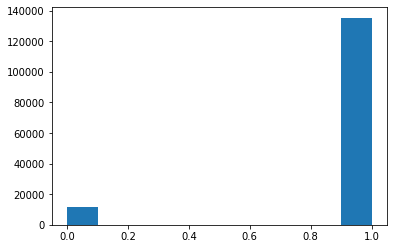

In [11]:
# Se realiza un recuento de las ocurrencias de la variable objetivo para el modelo taken
# Se puede visualizar que durante el modelado es necesario tener en cuenta el oversampling para lo cual es necesario
# realizar unos ajustes al set de entrenamiento

dataset_train = arch_fuente
clasesTieneAdicional = dataset_train.groupby('taken').size()

plt.hist(dataset_train['taken'])
plt.show()

## 3. Modelado
### _El objetivo de esta sección es entrenar y evaluar el modelo analítico que en este caso se va a probar_

In [12]:
# Se importan las librerías para utilizar el modelo Random Forest para una variable objetivo binaria, la librería
# que permite hacer el split de los datos para el set de prueba y de evaluación, las de las métricas del modelo y
# la librería que permite dar un manejo al over-sampling con el algoritmo SMOTE.

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import recall_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from imblearn.over_sampling import SMOTE

# Se dividen los sets de datos de entrenamiento y con un 80% y 20% respectivamente 
train_x, eval_x, \
train_y, eval_y, = train_test_split(dataset_train.drop(['taken'], axis=1),
                                               dataset_train['taken'],
                                               test_size = .2,
                                               random_state=19)

In [14]:
# Se utiliza el algoritmo SMOTE para manejar el oversampling
# Los sets de entrenamiento se ajustan para poder tomar decisiones de manera adecuada con la información disponible.

sm = SMOTE(random_state=19, ratio = 1.0)
train_x_sm, train_y_sm = sm.fit_sample(train_x, train_y)

In [15]:
# Una vez modificados los sets de entrenamiento para manejar el oversampling se procede a entrenar el modelo analítico

rf = RandomForestClassifier(n_estimators = 100, random_state = 19)
rf.fit(train_x_sm, train_y_sm)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=19, verbose=0,
                       warm_start=False)

## 4. Evaluación y análisis de resultados
### _El objetivo de esta sección es evaluar el modelo entrenado con los datos de prueba y analizar los resultados obtenidos_

In [85]:
# Predecir los datos de prueba con el modelo entrenado
predicciones = rf.predict(eval_x)


# Se obtienen dos métricas con base en las predicciones
print('Precisión y matriz de confusión:', accuracy_score(predicciones,eval_y))
print(confusion_matrix(predicciones,eval_y))
 


Precisión y matriz de confusión: 0.9033947887611402
[[  255   786]
 [ 2054 26303]]


In [86]:
# A continuación se van a análizar cuales son las variables mas importantes que se encuentran asociadas a no tomar una orden.

# Computar las importancias de las distintas variables en el arbol
importancias = list(rf.feature_importances_)

# Tuplas de variables e importancia de las mismas
lista_variables = dataset_train.drop(['taken'], axis=1)

feature_importances = [(feature, round(importance,2))for feature, importance in zip(lista_variables, importancias)] 

# Ordenar las tuplas por importancia
feature_importances = sorted(feature_importances, key = lambda x:x[1], reverse = True)

# Mostrar las importancias
[print ('Variable: {:10} Importance: {}'.format(*pair)) for pair in feature_importances];

# En esta salida se evidencia la importancia de los ingresos y edad de una persona para que acepten o no acepten 
# un pedido

Variable: dia        Importance: 0.32
Variable: hora       Importance: 0.27
Variable: to_user_elevation Importance: 0.16
Variable: to_user_distance Importance: 0.15
Variable: total_earning Importance: 0.09
